In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
import tensorflow as tf
import umap as umap

c:\users\karapardazesh\appdata\local\programs\python\python39\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\users\karapardazesh\appdata\local\programs\python\python39\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\users\karapardazesh\appdata\local\p

In [2]:
df = pd.read_csv("dataset.csv")
feature_columns=df.columns[2:]

In [3]:
df_cleaned = df.dropna()
X = df_cleaned[feature_columns]

scaler_X = StandardScaler()
scaler_X.fit(X,range)
X_scaled=scaler_X.transform(X)

In [4]:
print("NaNs in X_scaled:", np.isnan(X_scaled).sum())
print("Infinities in X_scaled:", np.isinf(X_scaled).sum())

NaNs in X_scaled: 0
Infinities in X_scaled: 0


In [6]:
X_train, X_val = train_test_split(X_scaled, test_size=0.1, random_state=42)



tf.random.set_seed(42)
input_dim = X_scaled.shape[1]


input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
#encoded = Dense(4, activation='relu')(encoded)

encoded = Dense(8, activation='relu')(encoded)

#decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=100,
                               restore_best_weights=True)

history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping],
                          verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
Total params: 1,352
Trainable params: 1,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
732/732 [==============================] - 1s 1

In [7]:
m=3.5

params = {
    # Font family
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],

    # Font sizes
    "axes.labelsize": 10*m,
    "font.size": 10*m,
    "legend.fontsize": 10*m,
    "xtick.labelsize": 9*m,
    "ytick.labelsize": 9*m,

    # Style for axis labels (xlabel, ylabel)
    'axes.labelweight': 'bold',
    'axes.labelcolor': 'black',

    # General styles for other elements
    'font.weight': 'bold',       # Makes title, etc., bold
    'xtick.color': 'black',      # Sets tick label color
    'ytick.color': 'black',
    'legend.labelcolor': 'black'
}

plt.rcParams.update(params)

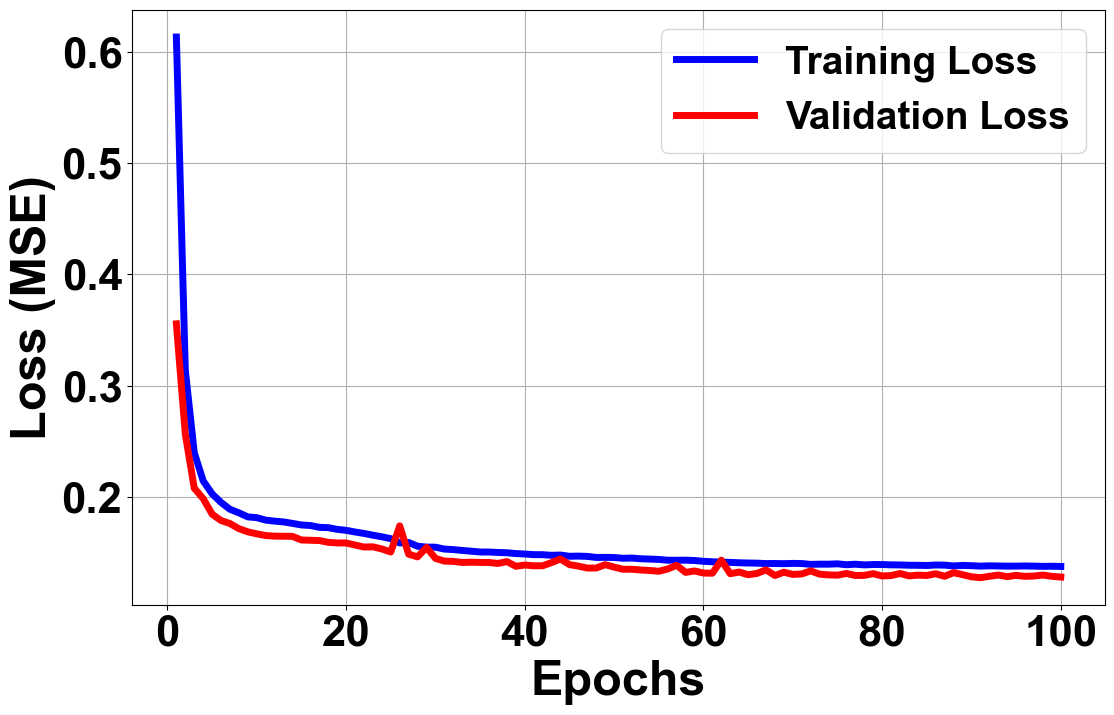

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ran = range(1, len(loss) + 1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(epochs_ran, loss, 'b', label='Training Loss',linewidth=5)
ax.plot(epochs_ran, val_loss, 'r', label='Validation Loss',linewidth=5)

plt.xlabel('Epochs',)
plt.ylabel('Loss (MSE)',)
plt.legend(prop={'size': m*8},markerscale=8)
plt.grid(True)
plt.tight_layout()
plt.savefig('Figs/fig2_loss_curve.pdf',dpi=600)

In [22]:
reconstructions = autoencoder.predict(X_scaled)
errors = np.mean(np.abs(X_scaled - reconstructions), axis=1)
df_cleaned['anomaly_score'] = errors

814/814 [==============================] - 1s 935us/step


C:\Users\KaraPardazesh\AppData\Local\Temp\ipykernel_1788\2710592948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['anomaly_score'] = errors


In [ ]:
df_cleaned.to_csv('anomaly.csv')

In [42]:
df_all=df_cleaned.copy().reset_index(drop=True)
allerrors=pd.DataFrame(np.abs(X_scaled - reconstructions))
allerrors.columns=features
for feat in features:
    df_all[f'anomaly_score_{feat}']=allerrors[feat]
df_all.to_csv('anomaly_all.csv')